In [1]:
import csv
import time as tm
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, Bidirectional

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('GOTO.csv', delimiter=',')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-17,218.0,218.0,210.0,214.0,214.0,516263700
1,2022-11-18,216.0,226.0,212.0,222.0,222.0,1401184800
2,2022-11-21,220.0,220.0,210.0,210.0,210.0,970473000
3,2022-11-22,210.0,210.0,196.0,196.0,196.0,1594524700
4,2022-11-23,192.0,198.0,190.0,191.0,191.0,876202200


In [4]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [5]:
df

,Date,Close
0,2022-11-17,214.0
1,2022-11-18,222.0
2,2022-11-21,210.0
3,2022-11-22,196.0
4,2022-11-23,191.0
...,...,...
238,2023-11-13,79.0
239,2023-11-14,81.0
240,2023-11-15,86.0
241,2023-11-16,86.0


In [6]:
N_STEPS = 7

LOOKUP_STEPS = [1, 2, 3]


# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

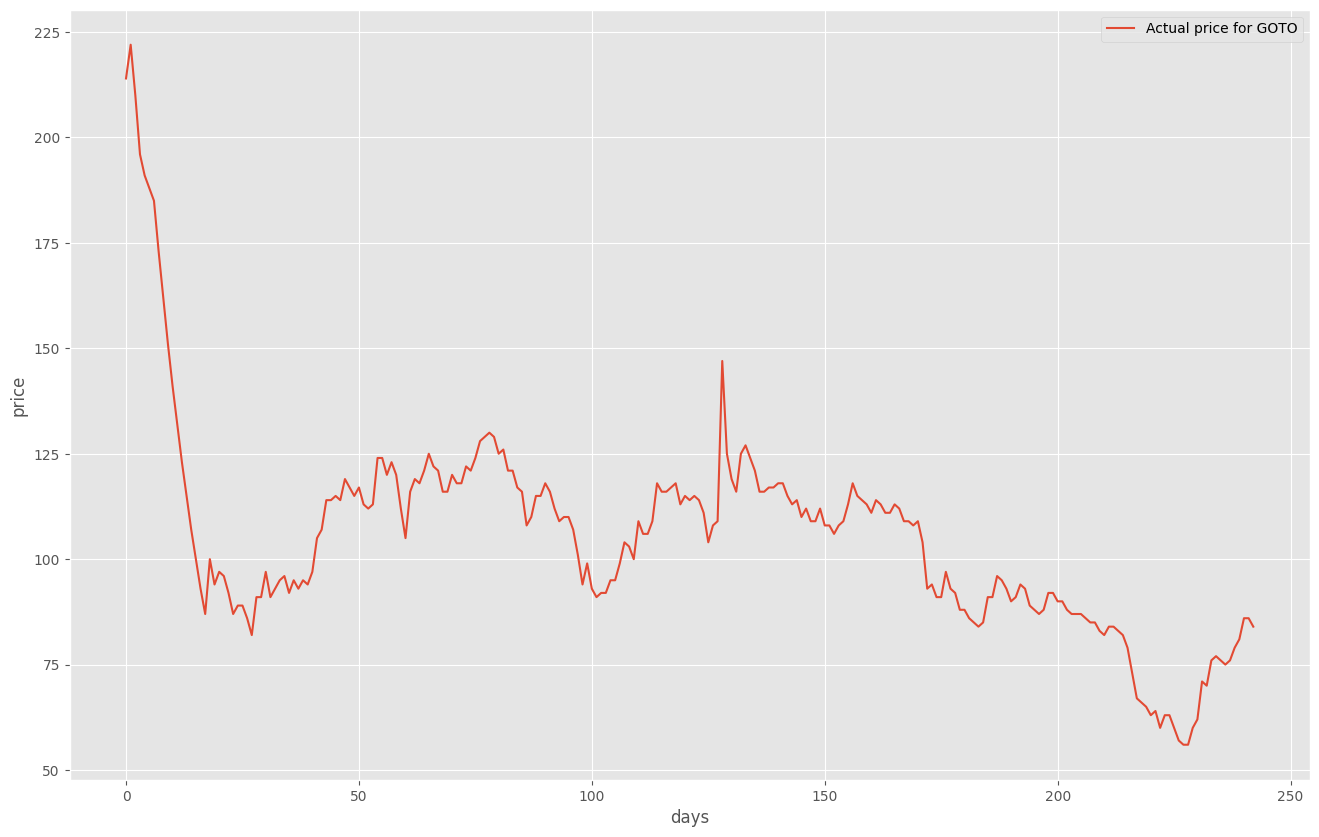

In [7]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for GOTO'])
plt.show()

In [8]:
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(np.expand_dims(df['Close'].values, axis=1))

In [9]:
df

,Date,Close
0,2022-11-17,0.951807
1,2022-11-18,1.000000
2,2022-11-21,0.927711
3,2022-11-22,0.843373
4,2022-11-23,0.813253
...,...,...
238,2023-11-13,0.138554
239,2023-11-14,0.150602
240,2023-11-15,0.180723
241,2023-11-16,0.180723


In [10]:
def PrepareData(days):
  df['Future'] = df['Close'].shift(-days)
  last_sequence = np.array(df[['Close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['Close'] + ['Date']].values, df['Future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['Close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [11]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Bidirectional(LSTM(120, return_sequences=True)))
  model.add(Dense(20))
  model.add(Bidirectional(LSTM(120, return_sequences=False)))
  model.add(Dropout(0.3))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='huber', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [12]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['Close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80


InternalError: Graph execution error:

Detected at node 'sequential/dense/Tensordot/MatMul' defined at (most recent call last):
    File "d:\Anaconda\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\Anaconda\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\Anaconda\envs\tf\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "d:\Anaconda\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "d:\Anaconda\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "d:\Anaconda\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "d:\Anaconda\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASUS TUF GAMING\AppData\Local\Temp\ipykernel_18064\853967543.py", line 7, in <module>
      model = GetTrainedModel(x_train, y_train)
    File "C:\Users\ASUS TUF GAMING\AppData\Local\Temp\ipykernel_18064\4018821947.py", line 15, in GetTrainedModel
      model.fit(x_train, y_train,
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\layers\core\dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'sequential/dense/Tensordot/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node sequential/dense/Tensordot/MatMul}}]] [Op:__inference_train_function_13267]

In [ ]:
if bool(predictions) == True and len(predictions) > 0 :
    predictions_list = [str(d)+'Rp' for d in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'GOTO price in {LOOKUP_STEPS} days will be {predictions_str}'
print(message)

GOTO price in [1, 2, 3] days will be 78.13Rp, 80.08Rp, 72.51Rp


In [ ]:
y_train[-3:]

array([0.09036145, 0.08433735, 0.12048193])

In [ ]:
def datetime_to_float(d):
    return d.timestamp()

8/8 [==============================] - 0s 6ms/step


C:\Users\ASUS TUF GAMING\AppData\Local\Temp\ipykernel_14592\2172665125.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  copy_df.loc[1] = [predictions[0], f'{1}', 0, 0]


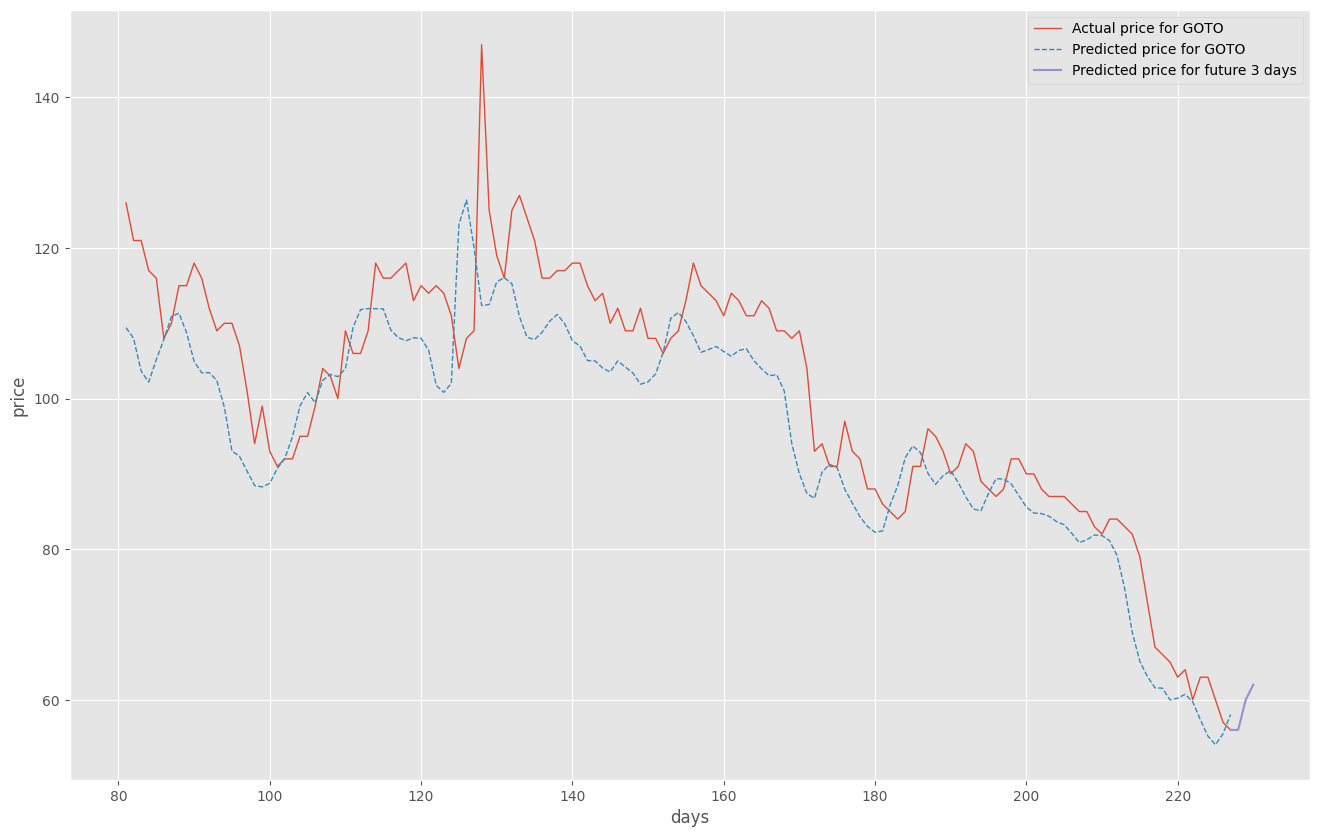

In [ ]:
copy_df = df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:3], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[1] = [predictions[0], f'{1}', 0, 0]
copy_df.loc[2] = [predictions[1], f'{2}', 0, 0]
copy_df.loc[3] = [predictions[2], f'{3}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
copy_df['Close'] = scaler.inverse_transform(np.expand_dims(copy_df['Close'], axis=1))
plt.plot(copy_df['Close'][-150:].head(147),linewidth=1)
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['Close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for GOTO', 
            f'Predicted price for GOTO',
            f'Predicted price for future 3 days'])
plt.show()

In [ ]:
model.save('stock_predict.h5')